In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.axes import Axes
import xesmf as xe
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate

/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
data_dir = 'chl.nc'  # daily
ds_chl_i = xr.open_dataset(data_dir, decode_times=False)

data_dir = 'ocean_temp_salt.res.nc'  # daily
ds_temp_salt = xr.open_dataset(data_dir)

data_dir = 'grid_spec.nc'  # daily
ds_grid_spec_720x410 = xr.open_dataset(data_dir)

data_dir = 'grid_spec_192_94_360_200.nc'  # daily
ds_grid_spec_360x200 = xr.open_dataset(data_dir)

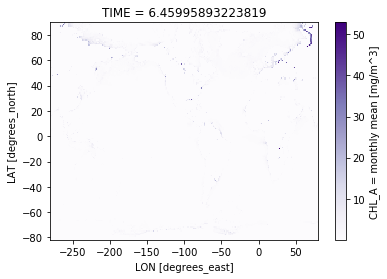

In [3]:
ds_chl_i.chl.isel(TIME=6).plot(cmap='Purples')

In [4]:
ds_chl_i['LON'] = ds_grid_spec_360x200.gridlon_t.values
ds_chl_i['LAT'] = ds_grid_spec_360x200.gridlat_t.values

In [5]:
ds_chl_i

<xarray.Dataset>
Dimensions:  (LAT: 200, LON: 360, TIME: 12)
Coordinates:
  * LON      (LON) float32 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
  * LAT      (LAT) float32 -81.5 -80.5 -79.5 -78.5 -77.5 ... 86.5 87.5 88.5 89.5
  * TIME     (TIME) float64 0.46 1.46 2.46 3.46 4.46 ... 8.46 9.46 10.46 11.46
Data variables:
    chl      (TIME, LAT, LON) float32 ...
Attributes:
    description:  CHL_A Climatology from GSFC monthly mean files, smoothed. 
    author:       Whit Anderson
    date:         07-Mar-2008

In [6]:
ds_out = xr.Dataset({'lat': (['lat'], ds_grid_spec_720x410.grid_y_T.values),
                     'lon': (['lon'], ds_grid_spec_720x410.grid_x_T.values),
                    }
                   )
ds_chl_i_ = ds_chl_i.rename({
  "LAT": "lat",
  "LON": "lon"
})

In [7]:
regridder = xe.Regridder(ds_chl_i_, ds_out, 'bilinear')

Create weight file: bilinear_200x360_410x720.nc


In [8]:
regridder.clean_weight_file()

Remove file bilinear_200x360_410x720.nc


In [9]:
ds_chl_o = regridder(ds_chl_i_)

using dimensions ('lat', 'lon') from data variable chl as the horizontal dimensions for this dataset.


/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [10]:
ds_chl_o

<xarray.Dataset>
Dimensions:  (TIME: 12, lat: 410, lon: 720)
Coordinates:
  * TIME     (TIME) float64 0.46 1.46 2.46 3.46 4.46 ... 8.46 9.46 10.46 11.46
  * lon      (lon) float32 -279.75 -279.25 -278.75 -278.25 ... 78.75 79.25 79.75
  * lat      (lat) float32 -80.75 -80.25 -79.75 -79.25 ... 88.75 89.25 89.75
Data variables:
    chl      (TIME, lat, lon) float64 0.0 0.2425 0.2425 0.2425 ... 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [11]:
ds_chl_o = ds_chl_o.rename({
  "lat": "LAT",
  "lon": "LON",
})

In [12]:
x = ds_chl_o.LON.values
ds_chl_o['LON'] = np.arange(x.shape[0], dtype=np.double)

y = ds_chl_o.LAT.values
ds_chl_o['LAT'] = np.arange(y.shape[0], dtype=np.double)

ds_chl_o.LON.attrs['units'] = 'degrees_east'
ds_chl_o.LON.attrs['axis'] = 'X'

ds_chl_o.LAT.attrs['units'] = 'degrees_north'
ds_chl_o.LAT.attrs['axis'] = 'Y'

ds_chl_o.chl.attrs['long_name'] = 'CHL_A = monthly mean'
ds_chl_o.chl.attrs['long_name_mod'] = 'From GSFC monthly mean files'
ds_chl_o.chl.attrs['units'] = 'mg/m^3'
ds_chl_o.chl.attrs['missing_value'] = -1.e+34
ds_chl_o.chl.attrs['_FillValue'] = -1.e+34

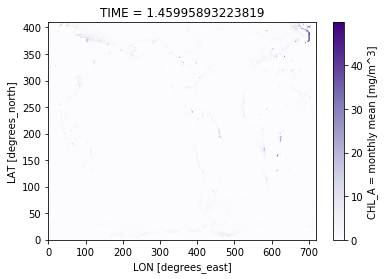

In [13]:
ds_chl_o.chl.isel(TIME=1).plot(cmap='Purples')

In [14]:
ds_chl_o.to_netcdf('chl.regrid.nc')

In [16]:
!ncks --mk_rec_dmn TIME chl.regrid.nc -o chl_regrid_unlimited.nc